# Mở đầu
Chương trình này mô phỏng cách ghép hai hình ảnh thành một ảnh lớn.
Đây là phương pháp chụp hình góc rộng được tích hợp vào hầu hết các ứng dụng chụp ảnh mặc định trên điện thoại.
Chương trình này có thể được mở rộng để ghép nhiều hơn 2 hình lại với nhau, tạo thành một bức hình panorama hoàn thiện. Dưới đây chúng ta sẽ tiến hành tải các thư viện cần thiết

In [2]:
%matplotlib inline
from skimage.feature import ORB, match_descriptors, plot_matches #các phương thức để phát hiện các features tương đồng của ảnh
from skimage.measure import ransac 
from skimage.io import imsave, show, imshow, imread #các hàm nhập, xuất, hiển thị và lưu ảnh
from skimage.color import gray2rgb, rgb2gray #biến đổi ảnh màu thành ảnh xám và ngược lại
from skimage.transform import warp #phương thức warp dùng để biến đổi một ảnh dựa trên transform đã có
from skimage.transform import SimilarityTransform ,ProjectiveTransform #hai phép biến hình được sử dụng để biến đổi ảnh
import numpy as np #thư viện xử lý số học numpy
import matplotlib.pyplot as plt

Chúng ta tiến hành đọc hai hình ảnh được chụp ở cùng một địa điểm nhưng dưới hai góc nhìn khác nhau

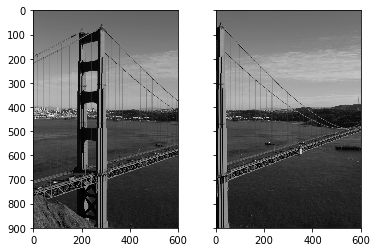

In [9]:
image0 = imread('goldengate1.png')
image0 = rgb2gray(image0)
image1 = imread('goldengate2.png')
image1 = rgb2gray(image1)
_, (plt1,plt2) = plt.subplots(1,2, sharey=True)
plt1.imshow(image0, cmap='gray')
plt2.imshow(image1, cmap='gray')

Giả sử rằng hình ảnh thứ nhất được nhìn bởi Thúy, hình hai được nhìn bởi Dung. Để ghép hai hình ảnh thành một, ta cần biến đổi hình ảnh của Dung thành một hình mà sao cho hình đó như được chụp từ góc nhìn của Thúy.
Để làm điều đó, trước hết hãy tìm ra các điểm chung của hai bức hình bằng thuật toán ORB

In [10]:
orb = ORB(n_keypoints=1000, fast_threshold=0.05)
orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors
orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Đoạn code phía trên, chúng ta thấy hai biến `keypoints1` và `keypoints2`, đây chính là những pixel của ảnh (egde, corners) được trích lọc từ ORB object. Các pixel này đại diện cho các đặc tính của hình được phát hiện bởi ORB 
Biến `matches12` sẽ lưu trữ chỉ số của những pixel có sự tương đồng với nhau (Ví dụ : đỉnh của hai cây cầu, cùng một chiếc xe chạy trên cầu).

Đoạn code dưới đây sẽ cho thấy các điểm ảnh nào tương đồng với nhau trong cả hai bức hình

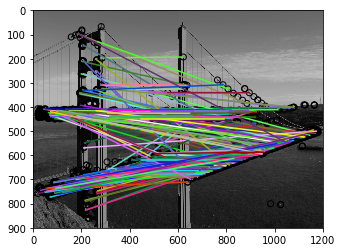

In [5]:
plot_matches(plt.axes(),image0,image1,keypoints1, keypoints2, matches12)

## Phần khó
Như đã nói phía trên, ta cần biến đổi hình ảnh thứ hai theo góc nhìn của hình ảnh thứ nhất. Làm thế nào để đạt được điều đó. Ta sử dụng cái gọi là các phép biến hình.
Có năm phép biến hình được sử dụng phổ biến trong xử lý ảnh, minh họa trong hình dưới đây (độ phức tạp tăng theo trục **X**)
![Image not found](https://kushalvyas.github.io/images/stitching/per.png)

Trong đoạn code này ta sử dụng hai phép đó là phép biến đổi tương đương (similarity) và phép chiếu (projective).
Phép Similarity dùng để biến đổi một hình ảnh trong hệ tọa độ mà nó được vẽ ra (phóng to, thu nhỏ, xoay , dịch chuyển). Phép Projective dùng để biến đổi một hình ảnh từ hệ tọa độ này sang hệ tọa độ khác, nói một cách đơn giản , tức là biến đổi hình ảnh được nhìn từ góc nhìn của người này, sang góc nhìn của người khác. Ở đây, chúng ta sẽ biến đổi hình ảnh được nhìn thấy bởi Dung thành một hình ảnh được nhìn thấy bởi Thúy

Do chúng ta muốn biến đổi góc nhìn từ Dung sang Thúy, nên các điểm ảnh trong bức hình của Dung sẽ được coi là điểm ảnh nguồn, của Thúy là điểm ảnh đích

In [47]:
#slice x:y:k , where k negative means inversing the order of elements
#we have to do this because keypoints returned by ORB have format of (y,x) or (row,column)
src = keypoints2[matches12[:, 1]][:, ::-1] 
dst = keypoints1[matches12[:, 0]][:, ::-1]

transform_model, inliers = \
ransac((src, dst), ProjectiveTransform, min_samples=4,
residual_threshold=2)

#ransac giúp tạo ra một mô hình mà giảm ảnh hưởng của các ngoại lệ
#Giống như cách tạo ra một learning model 

Chúng ta đưa vào hàm `ransac` một tập A chứa các pixel của ảnh nguồn, một tập B chứa các pixel của ảnh đích. `ransac` sẽ tạo ra một phép biến hình để chúng ta có thể biến đổi các hình ảnh từ góc nhìn của ảnh nguồn sang góc nhìn của ảnh đích.

In [48]:
r, c = image1.shape[:2]
#notice that because numpy's shape uses format (height,width,dimensions). e.g (row, columns, dimension_of_data)
#so the above shape would be the format of (height, width)
print(r,c)

900 600


In [49]:
corners = [
    [0,0],
    [0,r],
    [c,0],
    [c,r]
]
warpped_corners = transform_model(corners)
#here we calculate the size of output image to put two images in
all_corners = np.vstack((corners, warpped_corners))
min_corner = np.min(all_corners, axis = 0)
max_corner = np.max(all_corners, axis = 0)

#after having found the max and min corners, we simply subtract max_corner by min_corner to get the final size
image_size = max_corner - min_corner

#because image_size is (x,y) format while numpy matrices are (y,x), so we have to inverse it again

output_shape = np.ceil(image_size[::-1]).astype(int)
print(min_corner,max_corner)

[  0.         -37.47717635] [902.09673937 928.35686819]


(903, 966)

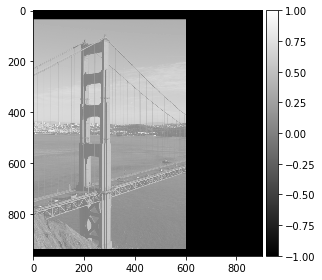

In [50]:
offset = SimilarityTransform(translation=-min_corner)
image0_warp = warp(image0, offset.inverse,output_shape=output_shape,
cval=-1)
imshow(image0_warp,cmap='gray')
image0_warp.shape[::-1]

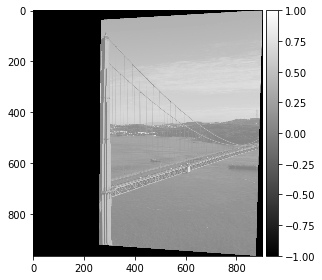

In [51]:
image1_warp = warp(image1, (transform_model+ offset).inverse,
output_shape=output_shape, cval=-1)
imshow(image1_warp,cmap='gray')
#biến đổi hình ảnh thứ 2 theo góc nhìn của hình ảnh thứ nhất

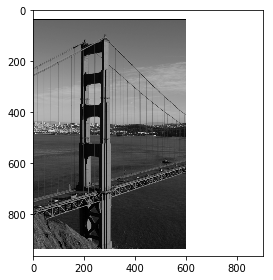

In [52]:
image0_mask = (image0_warp != -1)
image0_warp[~image0_mask] = 0
image0_alpha = np.dstack((gray2rgb(image0_warp), image0_mask))
imshow(image0_alpha)

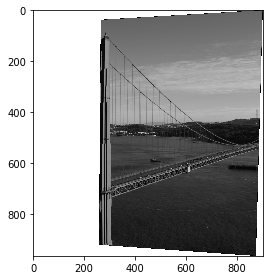

In [53]:
image1_mask = (image1_warp != -1)
image1_warp[~image1_mask] = 0
image1_alpha = np.dstack((gray2rgb(image1_warp), image1_mask))
imshow(image1_alpha)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


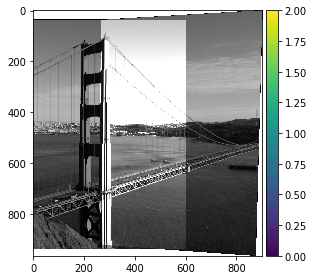

In [54]:
merged = (image0_alpha + image1_alpha)
imshow(merged)

In [55]:
alpha = merged[:,:,3]
merged /= np.maximum(alpha,1)[:,:,np.newaxis] #using np.maximum to ensure that dividing by zero would not happen
#np.newaxis usually used to increse number of demension of an array by 1

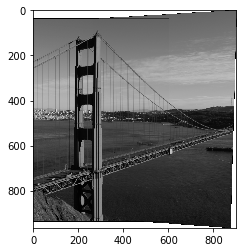

In [56]:
plt.imshow(merged)